In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Thu Jan 14 10:20:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 21%   36C    P0    32W / 250W |      0MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   34C    P0    33W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
import mlflow

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

'''
HELPER FUNCTIONS
'''
# From model/collectdata.py
from model.collectdata_mdsA import collect_data

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu, Results

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below

from model.models_mjp_19November20 import SimpleCNN5Layer_Ca_A as ModelA
from model.models_mjp_19November20 import SimpleCNN5Layer_Ca_E as ModelE
from model.models_mjp_19November20 import SimpleCNN7Layer_Ca_W as ModelW
from model.models_mjp_26December20 import SimpleCNN9Layer_Ca_X as ModelX
from model.models_mjp_26December20 import SimpleCNN7Layer_Ca_Y as ModelY

# From model/utilities.py
from model.utilities import load_full_state, count_parameters, Params

from model.plots import dual_train_plots, replace_in_ax

## adds image of model architecture
import hiddenlayer as HL

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [4]:
device = select_gpu(2)

1 available GPUs (initially using device 0):
  0 TITAN V


### Set up local parameters

In [5]:
# params order - batch size, epochs, lr, epoch_start (which is usually set to 0)
args = Params(128, 200, 1e-3, 20)

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [6]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('/share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5',
                             '/share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5',
#                             '/share/lazy/sokoloff/ML-data_AA/Oct03_40K_train.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_1.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_3.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_4.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_5.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_6.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_7.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_8.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_9.h5',
                            #'/share/lazy/sokoloff/ML-data_AA/Oct03_80K2_train.h5',
                             batch_size=args.batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                            device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=False,
                            load_xy=False)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=args.batch_size,
                          slice=slice(256 * 39),
                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=False,
                          load_xy=False)

Loading data...
Loaded /share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5 in 10.54 s
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5 in 10.29 s
Constructing 160000 event dataset took 3.144 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5 in 2.575 s
Constructing 9984 event dataset took 0.06682 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [7]:
model = ModelY()

##summary(model, input_size=(4, 4000))
##print(model.parameters)

mlflow.tracking.set_tracking_uri('file:/share/lazy/pv-finder_model_repo')
mlflow.set_experiment('Four Feature AllCNN')

Traceback (most recent call last):
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/share/lazy/pv-finder_model_repo/ML/meta.yaml' does not exist.


In [8]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


In [9]:
loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

##  use the first five layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113
##   ML -> /share/lazy/sokoloff/ML

# don't need this; likely relic code (keep for now)
#path = 'run_stats.pyt'
#load_full_state(model, optimizer, path)

# When loading pretrained models, use this code; otherwise, comment it out
# For other pretrained models, go to MLFlow and find the path for "run_stats.pyt"
pretrained_dict = '/share/lazy/pv-finder_model_repo/12/3bdf391886824901b0172ceff25d948e/artifacts/run_stats.pyt'
load_full_state(model, optimizer, pretrained_dict)

we also froze 0 weights
Of the 8.0 parameter layers to update in the current model, 8.0 were loaded


In [10]:
model.to(device)

SimpleCNN7Layer_Ca_Y(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(30, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(40, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(50, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv6): Conv1d(60, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv7): Conv1d(70, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
  (conv6dropout): Dropout(p=0.15, inplace=False)
  (conv7dropout): Dropout(p=0.35, inplace=False)
  (fc1): Linear(in_features=4000, out_features=4000, bias=True)
)

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


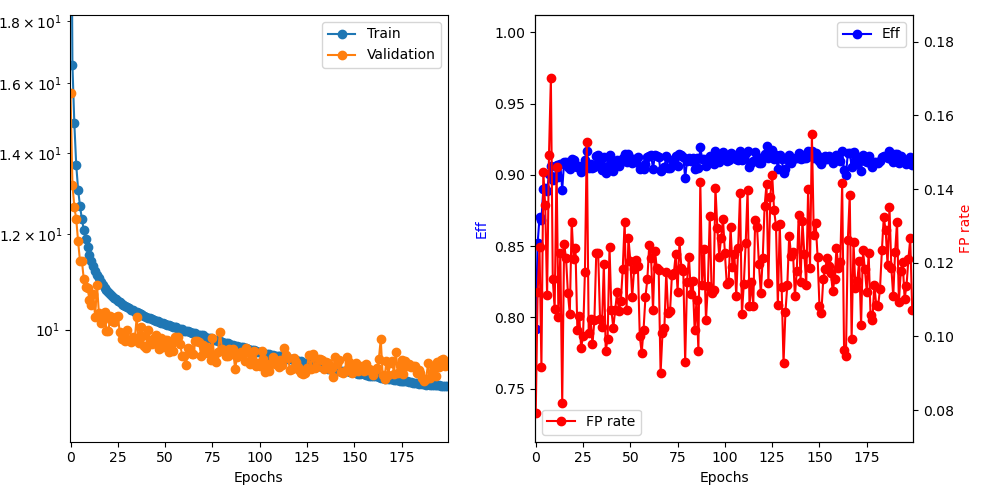

In [11]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

for model:  SimpleCNN7Layer_Ca_Y(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(30, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(40, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(50, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv6): Conv1d(60, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv7): Conv1d(70, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
  (conv6dropout): Dropout(p=0.15, inplace=False)
  (conv7dropout): Dropout(p=0.35, inplace=False)
  (fc1): Linear(in_features=4000, out_features=4000, bias=True)
)
epoch_start 20
batch_size 128
epochs 200
lr 0.001
Numbe

/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:95: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 20: train=30.4163, val=15.686, took 67.501 s
  Validation Found 43162 of 54504, added 792 (eff 79.19%) (0.0793 FP/event)
Result epoch:  20
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 21: train=16.5594, val=13.1858, took 67.191 s
  Validation Found 46432 of 54504, added 1118 (eff 85.19%) (0.112 FP/event)
Result epoch:  21
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 22: train=14.8292, val=12.636, took 67.027 s
  Validation Found 47426 of 54504, added 1240 (eff 87.01%) (0.124 FP/event)
Result epoch:  22
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 23: train=13.6908, val=12.3493, took 67.11 s
  Validation Found 47322 of 54504, added 916 (eff 86.82%) (0.0917 FP/event)
Result epoch:  23
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 24: train=13.0594, val=11.8314, took 67.173 s
  Validation Found 48512 of 54504, added 1444 (eff 89.01%) (0.145 FP/event)
Result epoch:  24
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 25: train=12.656, val=11.3923, took 67.0 s
  Validation Found 48542 of 54504, added 1354 (eff 89.06%) (0.136 FP/event)
Result epoch:  25
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 26: train=12.3458, val=11.4032, took 66.964 s
  Validation Found 48438 of 54504, added 1110 (eff 88.87%) (0.111 FP/event)
Result epoch:  26
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 27: train=12.0932, val=11.0076, took 66.971 s
  Validation Found 49078 of 54504, added 1490 (eff 90.04%) (0.149 FP/event)
Result epoch:  27
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 28: train=11.8782, val=10.8369, took 67.049 s
  Validation Found 49412 of 54504, added 1700 (eff 90.66%) (0.17 FP/event)
Result epoch:  28
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 29: train=11.7003, val=10.8331, took 67.019 s
  Validation Found 48843 of 54504, added 1154 (eff 89.61%) (0.116 FP/event)
Result epoch:  29
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 30: train=11.5304, val=10.5781, took 67.031 s
  Validation Found 48956 of 54504, added 1073 (eff 89.82%) (0.107 FP/event)
Result epoch:  30
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 31: train=11.4036, val=10.4722, took 67.509 s
  Validation Found 49450 of 54504, added 1457 (eff 90.73%) (0.146 FP/event)
Result epoch:  31
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 32: train=11.283, val=10.7049, took 67.078 s
  Validation Found 48991 of 54504, added 1050 (eff 89.89%) (0.105 FP/event)
Result epoch:  32
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 33: train=11.1753, val=10.252, took 67.01 s
  Validation Found 49454 of 54504, added 1225 (eff 90.73%) (0.123 FP/event)
Result epoch:  33
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 34: train=11.0931, val=10.8815, took 67.003 s
  Validation Found 48485 of 54504, added 818 (eff 88.96%) (0.0819 FP/event)
Result epoch:  34
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 35: train=11.0253, val=10.3194, took 66.992 s
  Validation Found 49562 of 54504, added 1248 (eff 90.93%) (0.125 FP/event)
Result epoch:  35
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 36: train=10.9541, val=10.1272, took 66.952 s
  Validation Found 49541 of 54504, added 1212 (eff 90.89%) (0.121 FP/event)
Result epoch:  36
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 37: train=10.8907, val=10.177, took 66.952 s
  Validation Found 49356 of 54504, added 1116 (eff 90.55%) (0.112 FP/event)
Result epoch:  37
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 38: train=10.833, val=10.3355, took 66.956 s
  Validation Found 49284 of 54504, added 1059 (eff 90.42%) (0.106 FP/event)
Result epoch:  38
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 39: train=10.7911, val=9.97759, took 66.965 s
  Validation Found 49667 of 54504, added 1310 (eff 91.13%) (0.131 FP/event)
Result epoch:  39
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 40: train=10.7505, val=9.96485, took 66.965 s
  Validation Found 49607 of 54504, added 1209 (eff 91.02%) (0.121 FP/event)
Result epoch:  40
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 41: train=10.6994, val=10.2607, took 66.973 s
  Validation Found 49387 of 54504, added 1239 (eff 90.61%) (0.124 FP/event)
Result epoch:  41
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 42: train=10.6644, val=10.1692, took 66.948 s
  Validation Found 49351 of 54504, added 1016 (eff 90.55%) (0.102 FP/event)
Result epoch:  42
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 43: train=10.6233, val=10.1464, took 67.086 s
  Validation Found 49409 of 54504, added 1054 (eff 90.65%) (0.106 FP/event)
Result epoch:  43
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 44: train=10.6075, val=10.2505, took 66.985 s
  Validation Found 49150 of 54504, added 967 (eff 90.18%) (0.0968 FP/event)
Result epoch:  44
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 45: train=10.5639, val=10.2559, took 67.022 s
  Validation Found 49307 of 54504, added 999 (eff 90.46%) (0.1 FP/event)
Result epoch:  45
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 46: train=10.5403, val=9.95947, took 67.018 s
  Validation Found 49622 of 54504, added 1173 (eff 91.04%) (0.117 FP/event)
Result epoch:  46
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 47: train=10.504, val=9.82566, took 66.931 s
  Validation Found 49982 of 54504, added 1526 (eff 91.70%) (0.153 FP/event)
Result epoch:  47
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 48: train=10.4787, val=9.90565, took 67.017 s
  Validation Found 49324 of 54504, added 1007 (eff 90.50%) (0.101 FP/event)
Result epoch:  48
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 49: train=10.4511, val=9.78383, took 67.022 s
  Validation Found 49483 of 54504, added 1045 (eff 90.79%) (0.105 FP/event)
Result epoch:  49
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 50: train=10.4345, val=9.99226, took 67.205 s
  Validation Found 49300 of 54504, added 978 (eff 90.45%) (0.0979 FP/event)
Result epoch:  50
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 51: train=10.416, val=9.80447, took 66.987 s
  Validation Found 49369 of 54504, added 1042 (eff 90.58%) (0.104 FP/event)
Result epoch:  51
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 52: train=10.3858, val=9.77508, took 67.027 s
  Validation Found 49766 of 54504, added 1224 (eff 91.31%) (0.123 FP/event)
Result epoch:  52
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 53: train=10.3744, val=9.85339, took 66.966 s
  Validation Found 49800 of 54504, added 1224 (eff 91.37%) (0.123 FP/event)
Result epoch:  53
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 54: train=10.3472, val=9.84171, took 66.919 s
  Validation Found 49536 of 54504, added 1045 (eff 90.89%) (0.105 FP/event)
Result epoch:  54
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 55: train=10.3347, val=10.2405, took 66.938 s
  Validation Found 49249 of 54504, added 1025 (eff 90.36%) (0.103 FP/event)
Result epoch:  55
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 56: train=10.3223, val=9.74829, took 66.954 s
  Validation Found 49755 of 54504, added 1195 (eff 91.29%) (0.12 FP/event)
Result epoch:  56
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 57: train=10.2967, val=10.0521, took 66.954 s
  Validation Found 49127 of 54504, added 960 (eff 90.13%) (0.0961 FP/event)
Result epoch:  57
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 58: train=10.282, val=9.8701, took 66.97 s
  Validation Found 49407 of 54504, added 991 (eff 90.65%) (0.0992 FP/event)
Result epoch:  58
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 59: train=10.2588, val=9.69364, took 66.977 s
  Validation Found 49804 of 54504, added 1242 (eff 91.38%) (0.124 FP/event)
Result epoch:  59
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 60: train=10.2416, val=9.66345, took 67.002 s
  Validation Found 49549 of 54504, added 1069 (eff 90.91%) (0.107 FP/event)
Result epoch:  60
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 61: train=10.23, val=9.99639, took 66.964 s
  Validation Found 49218 of 54504, added 1022 (eff 90.30%) (0.102 FP/event)
Result epoch:  61
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 62: train=10.2157, val=9.79577, took 66.967 s
  Validation Found 49379 of 54504, added 1070 (eff 90.60%) (0.107 FP/event)
Result epoch:  62
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 63: train=10.1948, val=9.7269, took 66.956 s
  Validation Found 49623 of 54504, added 1118 (eff 91.04%) (0.112 FP/event)
Result epoch:  63
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 64: train=10.1874, val=9.84759, took 66.969 s
  Validation Found 49401 of 54504, added 1067 (eff 90.64%) (0.107 FP/event)
Result epoch:  64
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 65: train=10.1666, val=9.9008, took 66.941 s
  Validation Found 49537 of 54504, added 1095 (eff 90.89%) (0.11 FP/event)
Result epoch:  65
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 66: train=10.1595, val=9.73131, took 66.955 s
  Validation Found 49686 of 54504, added 1182 (eff 91.16%) (0.118 FP/event)
Result epoch:  66
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 67: train=10.1529, val=9.63882, took 66.971 s
  Validation Found 49841 of 54504, added 1310 (eff 91.44%) (0.131 FP/event)
Result epoch:  67
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 68: train=10.1335, val=9.83398, took 66.915 s
  Validation Found 49535 of 54504, added 1071 (eff 90.88%) (0.107 FP/event)
Result epoch:  68
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 69: train=10.1271, val=9.67704, took 66.922 s
  Validation Found 49848 of 54504, added 1265 (eff 91.46%) (0.127 FP/event)
Result epoch:  69
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 70: train=10.1056, val=9.80027, took 66.926 s
  Validation Found 49695 of 54504, added 1204 (eff 91.18%) (0.121 FP/event)
Result epoch:  70
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 71: train=10.0831, val=9.79498, took 66.962 s
  Validation Found 49501 of 54504, added 1105 (eff 90.82%) (0.111 FP/event)
Result epoch:  71
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 72: train=10.0846, val=9.59057, took 66.999 s
  Validation Found 49654 of 54504, added 1180 (eff 91.10%) (0.118 FP/event)
Result epoch:  72
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 73: train=10.0685, val=9.71519, took 66.984 s
  Validation Found 49557 of 54504, added 1205 (eff 90.92%) (0.121 FP/event)
Result epoch:  73
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 74: train=10.051, val=9.60135, took 66.993 s
  Validation Found 49747 of 54504, added 1189 (eff 91.27%) (0.119 FP/event)
Result epoch:  74
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 75: train=10.0465, val=9.85098, took 66.945 s
  Validation Found 49289 of 54504, added 1000 (eff 90.43%) (0.1 FP/event)
Result epoch:  75
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 76: train=10.0533, val=9.79998, took 66.966 s
  Validation Found 49353 of 54504, added 953 (eff 90.55%) (0.0954 FP/event)
Result epoch:  76
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 77: train=10.0201, val=9.861, took 66.981 s
  Validation Found 49292 of 54504, added 1017 (eff 90.44%) (0.102 FP/event)
Result epoch:  77
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 78: train=10.0059, val=9.73317, took 66.961 s
  Validation Found 49460 of 54504, added 1105 (eff 90.75%) (0.111 FP/event)
Result epoch:  78
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 79: train=10.0041, val=9.50461, took 66.981 s
  Validation Found 49724 of 54504, added 1154 (eff 91.23%) (0.116 FP/event)
Result epoch:  79
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 80: train=9.98023, val=9.50042, took 66.973 s
  Validation Found 49793 of 54504, added 1246 (eff 91.36%) (0.125 FP/event)
Result epoch:  80
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 81: train=9.97634, val=9.34627, took 66.952 s
  Validation Found 49815 of 54504, added 1211 (eff 91.40%) (0.121 FP/event)
Result epoch:  81
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 82: train=9.96409, val=9.64836, took 66.974 s
  Validation Found 49294 of 54504, added 1069 (eff 90.44%) (0.107 FP/event)
Result epoch:  82
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 83: train=9.94704, val=9.63827, took 66.968 s
  Validation Found 49797 of 54504, added 1231 (eff 91.36%) (0.123 FP/event)
Result epoch:  83
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 84: train=9.92784, val=9.55043, took 67.026 s
  Validation Found 49768 of 54504, added 1184 (eff 91.31%) (0.119 FP/event)
Result epoch:  84
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 85: train=9.93739, val=9.54061, took 66.999 s
  Validation Found 49742 of 54504, added 1178 (eff 91.26%) (0.118 FP/event)
Result epoch:  85
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 86: train=9.93115, val=9.78726, took 67.003 s
  Validation Found 49199 of 54504, added 898 (eff 90.27%) (0.0899 FP/event)
Result epoch:  86
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 87: train=9.89642, val=9.77846, took 66.955 s
  Validation Found 49298 of 54504, added 1007 (eff 90.45%) (0.101 FP/event)
Result epoch:  87
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 88: train=9.89452, val=9.76644, took 66.966 s
  Validation Found 49345 of 54504, added 1020 (eff 90.53%) (0.102 FP/event)
Result epoch:  88
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 89: train=9.88975, val=9.51627, took 66.924 s
  Validation Found 49766 of 54504, added 1174 (eff 91.31%) (0.118 FP/event)
Result epoch:  89
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 90: train=9.8897, val=9.70974, took 66.915 s
  Validation Found 49334 of 54504, added 1061 (eff 90.51%) (0.106 FP/event)
Result epoch:  90
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 91: train=9.86681, val=9.57081, took 67.093 s
  Validation Found 49335 of 54504, added 1067 (eff 90.52%) (0.107 FP/event)
Result epoch:  91
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 92: train=9.84687, val=9.66645, took 66.975 s
  Validation Found 49640 of 54504, added 1165 (eff 91.08%) (0.117 FP/event)
Result epoch:  92
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 93: train=9.83287, val=9.5594, took 66.994 s
  Validation Found 49616 of 54504, added 1170 (eff 91.03%) (0.117 FP/event)
Result epoch:  93
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 94: train=9.84061, val=9.43162, took 67.008 s
  Validation Found 49788 of 54504, added 1221 (eff 91.35%) (0.122 FP/event)
Result epoch:  94
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 95: train=9.81605, val=9.8393, took 66.983 s
  Validation Found 49408 of 54504, added 1119 (eff 90.65%) (0.112 FP/event)
Result epoch:  95
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 96: train=9.80892, val=9.49087, took 67.064 s
  Validation Found 49855 of 54504, added 1257 (eff 91.47%) (0.126 FP/event)
Result epoch:  96
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 97: train=9.79666, val=9.40396, took 66.96 s
  Validation Found 49802 of 54504, added 1184 (eff 91.37%) (0.119 FP/event)
Result epoch:  97
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 98: train=9.78389, val=9.57865, took 66.975 s
  Validation Found 49736 of 54504, added 1177 (eff 91.25%) (0.118 FP/event)
Result epoch:  98
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 99: train=9.79241, val=9.9553, took 66.958 s
  Validation Found 48940 of 54504, added 929 (eff 89.79%) (0.093 FP/event)
Result epoch:  99
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 100: train=9.76311, val=9.63776, took 66.966 s
  Validation Found 49598 of 54504, added 1147 (eff 91.00%) (0.115 FP/event)
Result epoch:  100
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 101: train=9.75646, val=9.60678, took 67.108 s
  Validation Found 49703 of 54504, added 1215 (eff 91.19%) (0.122 FP/event)
Result epoch:  101
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 102: train=9.7556, val=9.5096, took 67.034 s
  Validation Found 49592 of 54504, added 1114 (eff 90.99%) (0.112 FP/event)
Result epoch:  102
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 103: train=9.74235, val=9.50731, took 66.961 s
  Validation Found 49711 of 54504, added 1150 (eff 91.21%) (0.115 FP/event)
Result epoch:  103
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 104: train=9.73548, val=9.64499, took 66.968 s
  Validation Found 49278 of 54504, added 1017 (eff 90.41%) (0.102 FP/event)
Result epoch:  104
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 105: train=9.71551, val=9.5456, took 67.033 s
  Validation Found 49686 of 54504, added 1096 (eff 91.16%) (0.11 FP/event)
Result epoch:  105
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 106: train=9.71154, val=9.63232, took 67.07 s
  Validation Found 49305 of 54504, added 960 (eff 90.46%) (0.0961 FP/event)
Result epoch:  106
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 107: train=9.70087, val=9.26865, took 66.98 s
  Validation Found 50106 of 54504, added 1417 (eff 91.93%) (0.142 FP/event)
Result epoch:  107
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 108: train=9.69262, val=9.48535, took 66.978 s
  Validation Found 49657 of 54504, added 1139 (eff 91.11%) (0.114 FP/event)
Result epoch:  108
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 109: train=9.68093, val=9.54884, took 66.994 s
  Validation Found 49670 of 54504, added 1235 (eff 91.13%) (0.124 FP/event)
Result epoch:  109
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 110: train=9.67259, val=9.57783, took 67.028 s
  Validation Found 49399 of 54504, added 1042 (eff 90.63%) (0.104 FP/event)
Result epoch:  110
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 111: train=9.66736, val=9.55702, took 67.151 s
  Validation Found 49657 of 54504, added 1136 (eff 91.11%) (0.114 FP/event)
Result epoch:  111
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 112: train=9.64487, val=9.427, took 66.962 s
  Validation Found 49787 of 54504, added 1325 (eff 91.35%) (0.133 FP/event)
Result epoch:  112
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 113: train=9.64866, val=9.65695, took 66.949 s
  Validation Found 49543 of 54504, added 1116 (eff 90.90%) (0.112 FP/event)
Result epoch:  113
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 114: train=9.63699, val=9.58098, took 66.945 s
  Validation Found 49486 of 54504, added 1123 (eff 90.79%) (0.112 FP/event)
Result epoch:  114
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 115: train=9.62221, val=9.36955, took 66.976 s
  Validation Found 49963 of 54504, added 1402 (eff 91.67%) (0.14 FP/event)
Result epoch:  115
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 116: train=9.62427, val=9.47888, took 66.986 s
  Validation Found 49794 of 54504, added 1292 (eff 91.36%) (0.129 FP/event)
Result epoch:  116
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 117: train=9.6193, val=9.60526, took 67.011 s
  Validation Found 49551 of 54504, added 1215 (eff 90.91%) (0.122 FP/event)
Result epoch:  117
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 118: train=9.60537, val=9.33497, took 66.989 s
  Validation Found 49864 of 54504, added 1265 (eff 91.49%) (0.127 FP/event)
Result epoch:  118
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 119: train=9.5879, val=9.38971, took 66.965 s
  Validation Found 49925 of 54504, added 1318 (eff 91.60%) (0.132 FP/event)
Result epoch:  119
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 120: train=9.58295, val=9.33382, took 66.971 s
  Validation Found 49742 of 54504, added 1224 (eff 91.26%) (0.123 FP/event)
Result epoch:  120
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 121: train=9.56611, val=9.5929, took 66.955 s
  Validation Found 49604 of 54504, added 1140 (eff 91.01%) (0.114 FP/event)
Result epoch:  121
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 122: train=9.56319, val=9.45775, took 66.977 s
  Validation Found 49608 of 54504, added 1146 (eff 91.02%) (0.115 FP/event)
Result epoch:  122
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 123: train=9.54362, val=9.22262, took 66.964 s
  Validation Found 49899 of 54504, added 1295 (eff 91.55%) (0.13 FP/event)
Result epoch:  123
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 124: train=9.53801, val=9.32276, took 67.004 s
  Validation Found 49810 of 54504, added 1186 (eff 91.39%) (0.119 FP/event)
Result epoch:  124
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 125: train=9.53804, val=9.23623, took 66.99 s
  Validation Found 49828 of 54504, added 1223 (eff 91.42%) (0.122 FP/event)
Result epoch:  125
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 126: train=9.50986, val=9.37553, took 67.583 s
  Validation Found 49648 of 54504, added 1108 (eff 91.09%) (0.111 FP/event)
Result epoch:  126
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 127: train=9.51901, val=9.4862, took 67.008 s
  Validation Found 49612 of 54504, added 1237 (eff 91.02%) (0.124 FP/event)
Result epoch:  127
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 128: train=9.51463, val=9.37037, took 66.984 s
  Validation Found 49973 of 54504, added 1386 (eff 91.69%) (0.139 FP/event)
Result epoch:  128
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 129: train=9.50532, val=9.36137, took 66.989 s
  Validation Found 49632 of 54504, added 1058 (eff 91.06%) (0.106 FP/event)
Result epoch:  129
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 130: train=9.51253, val=9.30899, took 66.996 s
  Validation Found 49667 of 54504, added 1141 (eff 91.13%) (0.114 FP/event)
Result epoch:  130
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 131: train=9.50891, val=9.42819, took 66.976 s
  Validation Found 49878 of 54504, added 1252 (eff 91.51%) (0.125 FP/event)
Result epoch:  131
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 132: train=9.49057, val=9.33868, took 66.932 s
  Validation Found 49961 of 54504, added 1396 (eff 91.66%) (0.14 FP/event)
Result epoch:  132
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 133: train=9.49127, val=9.65909, took 66.943 s
  Validation Found 49346 of 54504, added 1081 (eff 90.54%) (0.108 FP/event)
Result epoch:  133
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 134: train=9.46828, val=9.53414, took 66.946 s
  Validation Found 49516 of 54504, added 1146 (eff 90.85%) (0.115 FP/event)
Result epoch:  134
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 135: train=9.46335, val=9.47312, took 66.91 s
  Validation Found 49600 of 54504, added 1082 (eff 91.00%) (0.108 FP/event)
Result epoch:  135
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 136: train=9.45858, val=9.25987, took 66.955 s
  Validation Found 49939 of 54504, added 1313 (eff 91.62%) (0.131 FP/event)
Result epoch:  136
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 137: train=9.45278, val=9.28113, took 67.019 s
  Validation Found 49736 of 54504, added 1295 (eff 91.25%) (0.13 FP/event)
Result epoch:  137
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 138: train=9.43454, val=9.47277, took 66.967 s
  Validation Found 49521 of 54504, added 1194 (eff 90.86%) (0.12 FP/event)
Result epoch:  138
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 139: train=9.43513, val=9.4005, took 66.941 s
  Validation Found 49526 of 54504, added 1115 (eff 90.87%) (0.112 FP/event)
Result epoch:  139
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 140: train=9.42355, val=9.31615, took 66.974 s
  Validation Found 49750 of 54504, added 1211 (eff 91.28%) (0.121 FP/event)
Result epoch:  140
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 141: train=9.39776, val=9.25787, took 66.892 s
  Validation Found 49837 of 54504, added 1352 (eff 91.44%) (0.135 FP/event)
Result epoch:  141
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 142: train=9.41105, val=9.2074, took 67.01 s
  Validation Found 50155 of 54504, added 1411 (eff 92.02%) (0.141 FP/event)
Result epoch:  142
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 143: train=9.38559, val=9.19019, took 67.666 s
  Validation Found 49692 of 54504, added 1143 (eff 91.17%) (0.114 FP/event)
Result epoch:  143
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 144: train=9.38387, val=9.21132, took 66.936 s
  Validation Found 49877 of 54504, added 1377 (eff 91.51%) (0.138 FP/event)
Result epoch:  144
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 145: train=9.36678, val=9.2872, took 67.07 s
  Validation Found 50005 of 54504, added 1437 (eff 91.75%) (0.144 FP/event)
Result epoch:  145
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 146: train=9.36003, val=9.51834, took 66.977 s
  Validation Found 49671 of 54504, added 1341 (eff 91.13%) (0.134 FP/event)
Result epoch:  146
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 147: train=9.35061, val=9.27361, took 66.955 s
  Validation Found 49812 of 54504, added 1299 (eff 91.39%) (0.13 FP/event)
Result epoch:  147
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 148: train=9.3405, val=9.55382, took 66.966 s
  Validation Found 49262 of 54504, added 1083 (eff 90.38%) (0.108 FP/event)
Result epoch:  148
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 149: train=9.33602, val=9.29924, took 66.974 s
  Validation Found 49808 of 54504, added 1302 (eff 91.38%) (0.13 FP/event)
Result epoch:  149
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 150: train=9.33107, val=9.31087, took 66.971 s
  Validation Found 49673 of 54504, added 1133 (eff 91.14%) (0.113 FP/event)
Result epoch:  150
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 151: train=9.32078, val=9.4537, took 67.021 s
  Validation Found 49132 of 54504, added 925 (eff 90.14%) (0.0926 FP/event)
Result epoch:  151
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 152: train=9.33317, val=9.45764, took 66.987 s
  Validation Found 49276 of 54504, added 1064 (eff 90.41%) (0.107 FP/event)
Result epoch:  152
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 153: train=9.30507, val=9.43106, took 67.249 s
  Validation Found 49655 of 54504, added 1138 (eff 91.10%) (0.114 FP/event)
Result epoch:  153
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 154: train=9.30376, val=9.28, took 67.004 s
  Validation Found 49814 of 54504, added 1272 (eff 91.40%) (0.127 FP/event)
Result epoch:  154
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 155: train=9.29368, val=9.3929, took 66.141 s
  Validation Found 49501 of 54504, added 1217 (eff 90.82%) (0.122 FP/event)
Result epoch:  155
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 156: train=9.28318, val=9.37794, took 66.977 s
  Validation Found 49678 of 54504, added 1228 (eff 91.15%) (0.123 FP/event)
Result epoch:  156
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 157: train=9.2848, val=9.28085, took 66.961 s
  Validation Found 49686 of 54504, added 1107 (eff 91.16%) (0.111 FP/event)
Result epoch:  157
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 158: train=9.28185, val=9.29138, took 66.922 s
  Validation Found 49681 of 54504, added 1175 (eff 91.15%) (0.118 FP/event)
Result epoch:  158
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 159: train=9.27133, val=9.13731, took 67.299 s
  Validation Found 49874 of 54504, added 1327 (eff 91.51%) (0.133 FP/event)
Result epoch:  159
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 160: train=9.25045, val=9.49596, took 67.009 s
  Validation Found 49679 of 54504, added 1147 (eff 91.15%) (0.115 FP/event)
Result epoch:  160
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 161: train=9.26121, val=9.36139, took 66.994 s
  Validation Found 49812 of 54504, added 1312 (eff 91.39%) (0.131 FP/event)
Result epoch:  161
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 162: train=9.24719, val=9.43665, took 66.959 s
  Validation Found 49702 of 54504, added 1222 (eff 91.19%) (0.122 FP/event)
Result epoch:  162
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 163: train=9.23889, val=9.21788, took 66.983 s
  Validation Found 49683 of 54504, added 1138 (eff 91.15%) (0.114 FP/event)
Result epoch:  163
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 164: train=9.23917, val=9.20902, took 66.958 s
  Validation Found 49979 of 54504, added 1398 (eff 91.70%) (0.14 FP/event)
Result epoch:  164
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 165: train=9.24306, val=9.23769, took 66.951 s
  Validation Found 49777 of 54504, added 1185 (eff 91.33%) (0.119 FP/event)
Result epoch:  165
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 166: train=9.24603, val=9.48656, took 67.217 s
  Validation Found 49979 of 54504, added 1547 (eff 91.70%) (0.155 FP/event)
Result epoch:  166
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 167: train=9.23858, val=9.39783, took 67.026 s
  Validation Found 49691 of 54504, added 1273 (eff 91.17%) (0.127 FP/event)
Result epoch:  167
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 168: train=9.22349, val=9.31454, took 66.944 s
  Validation Found 49892 of 54504, added 1305 (eff 91.54%) (0.131 FP/event)
Result epoch:  168
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 169: train=9.21996, val=9.20461, took 66.955 s
  Validation Found 49783 of 54504, added 1215 (eff 91.34%) (0.122 FP/event)
Result epoch:  169
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 170: train=9.21733, val=9.31325, took 66.961 s
  Validation Found 49571 of 54504, added 1081 (eff 90.95%) (0.108 FP/event)
Result epoch:  170
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 171: train=9.2143, val=9.38207, took 66.994 s
  Validation Found 49480 of 54504, added 1062 (eff 90.78%) (0.106 FP/event)
Result epoch:  171
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 172: train=9.19339, val=9.23907, took 67.0 s
  Validation Found 49623 of 54504, added 1154 (eff 91.04%) (0.116 FP/event)
Result epoch:  172
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 173: train=9.18914, val=9.3055, took 66.927 s
  Validation Found 49778 of 54504, added 1180 (eff 91.33%) (0.118 FP/event)
Result epoch:  173
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 174: train=9.20358, val=9.332, took 67.158 s
  Validation Found 49666 of 54504, added 1210 (eff 91.12%) (0.121 FP/event)
Result epoch:  174
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 175: train=9.19624, val=9.24627, took 67.028 s
  Validation Found 49758 of 54504, added 1189 (eff 91.29%) (0.119 FP/event)
Result epoch:  175
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 176: train=9.1699, val=9.35823, took 67.044 s
  Validation Found 49677 of 54504, added 1171 (eff 91.14%) (0.117 FP/event)
Result epoch:  176
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 177: train=9.17122, val=9.25875, took 67.008 s
  Validation Found 49494 of 54504, added 1121 (eff 90.81%) (0.112 FP/event)
Result epoch:  177
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 178: train=9.1601, val=9.27402, took 67.008 s
  Validation Found 49623 of 54504, added 1154 (eff 91.04%) (0.116 FP/event)
Result epoch:  178
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 179: train=9.15307, val=9.26203, took 67.188 s
  Validation Found 49827 of 54504, added 1238 (eff 91.42%) (0.124 FP/event)
Result epoch:  179
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 180: train=9.14881, val=9.16541, took 67.072 s
  Validation Found 49752 of 54504, added 1184 (eff 91.28%) (0.119 FP/event)
Result epoch:  180
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 181: train=9.14859, val=9.25771, took 67.449 s
  Validation Found 49585 of 54504, added 1200 (eff 90.97%) (0.12 FP/event)
Result epoch:  181
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 182: train=9.14598, val=9.28932, took 67.077 s
  Validation Found 49957 of 54504, added 1414 (eff 91.66%) (0.142 FP/event)
Result epoch:  182
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 183: train=9.12936, val=9.45529, took 67.022 s
  Validation Found 49222 of 54504, added 961 (eff 90.31%) (0.0962 FP/event)
Result epoch:  183
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 184: train=9.12346, val=9.81903, took 67.044 s
  Validation Found 49062 of 54504, added 946 (eff 90.02%) (0.0947 FP/event)
Result epoch:  184
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 185: train=9.11948, val=9.17823, took 67.002 s
  Validation Found 49881 of 54504, added 1261 (eff 91.52%) (0.126 FP/event)
Result epoch:  185
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 186: train=9.10691, val=9.10534, took 66.988 s
  Validation Found 49907 of 54504, added 1382 (eff 91.57%) (0.138 FP/event)
Result epoch:  186
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 187: train=9.11497, val=9.42633, took 66.986 s
  Validation Found 49371 of 54504, added 991 (eff 90.58%) (0.0992 FP/event)
Result epoch:  187
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 188: train=9.10002, val=9.17707, took 67.082 s
  Validation Found 49924 of 54504, added 1254 (eff 91.60%) (0.126 FP/event)
Result epoch:  188
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 189: train=9.09839, val=9.38312, took 67.133 s
  Validation Found 49537 of 54504, added 1130 (eff 90.89%) (0.113 FP/event)
Result epoch:  189
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 190: train=9.09375, val=9.41613, took 67.026 s
  Validation Found 49471 of 54504, added 1149 (eff 90.77%) (0.115 FP/event)
Result epoch:  190
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 191: train=9.09225, val=9.1892, took 67.01 s
  Validation Found 49755 of 54504, added 1204 (eff 91.29%) (0.121 FP/event)
Result epoch:  191
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 192: train=9.08152, val=9.58303, took 67.0 s
  Validation Found 49203 of 54504, added 1029 (eff 90.27%) (0.103 FP/event)
Result epoch:  192
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 193: train=9.08782, val=9.20065, took 67.028 s
  Validation Found 49817 of 54504, added 1233 (eff 91.40%) (0.123 FP/event)
Result epoch:  193
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 194: train=9.06645, val=9.33857, took 67.082 s
  Validation Found 49604 of 54504, added 1180 (eff 91.01%) (0.118 FP/event)
Result epoch:  194
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 195: train=9.0658, val=9.42835, took 67.063 s
  Validation Found 49540 of 54504, added 1120 (eff 90.89%) (0.112 FP/event)
Result epoch:  195
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 196: train=9.06005, val=9.19176, took 67.061 s
  Validation Found 49780 of 54504, added 1224 (eff 91.33%) (0.123 FP/event)
Result epoch:  196
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 197: train=9.06068, val=9.42344, took 67.034 s
  Validation Found 49489 of 54504, added 1056 (eff 90.80%) (0.106 FP/event)
Result epoch:  197
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 198: train=9.06541, val=9.33449, took 67.221 s
  Validation Found 49357 of 54504, added 1043 (eff 90.56%) (0.104 FP/event)
Result epoch:  198
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 199: train=9.05449, val=9.36273, took 67.003 s
  Validation Found 49528 of 54504, added 1139 (eff 90.87%) (0.114 FP/event)
Result epoch:  199
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 200: train=9.05038, val=9.31832, took 67.002 s
  Validation Found 49532 of 54504, added 1084 (eff 90.88%) (0.109 FP/event)
Result epoch:  200
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 201: train=9.03526, val=9.33074, took 66.861 s
  Validation Found 49513 of 54504, added 1081 (eff 90.84%) (0.108 FP/event)
Result epoch:  201
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 202: train=9.02833, val=9.32136, took 66.34 s
  Validation Found 49588 of 54504, added 1127 (eff 90.98%) (0.113 FP/event)
Result epoch:  202
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 203: train=9.03182, val=9.21242, took 65.988 s
  Validation Found 49729 of 54504, added 1232 (eff 91.24%) (0.123 FP/event)
Result epoch:  203
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 204: train=9.02074, val=9.26022, took 67.007 s
  Validation Found 49792 of 54504, added 1322 (eff 91.35%) (0.132 FP/event)
Result epoch:  204
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 205: train=9.03734, val=9.19865, took 67.003 s
  Validation Found 49785 of 54504, added 1286 (eff 91.34%) (0.129 FP/event)
Result epoch:  205
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 206: train=9.01695, val=9.12183, took 67.052 s
  Validation Found 49700 of 54504, added 1191 (eff 91.19%) (0.119 FP/event)
Result epoch:  206
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 207: train=9.01817, val=9.06311, took 66.988 s
  Validation Found 49972 of 54504, added 1350 (eff 91.69%) (0.135 FP/event)
Result epoch:  207
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 208: train=9.0054, val=9.09532, took 66.968 s
  Validation Found 49677 of 54504, added 1184 (eff 91.14%) (0.119 FP/event)
Result epoch:  208
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 209: train=9.00808, val=9.38002, took 66.989 s
  Validation Found 49540 of 54504, added 1107 (eff 90.89%) (0.111 FP/event)
Result epoch:  209
Average Eff:  0.0
Average FP Rate:  0.0


Epoch 210: train=9.00347, val=9.11096, took 66.982 s
  Validation Found 49857 of 54504, added 1228 (eff 91.47%) (0.123 FP/event)
Result epoch:  210
Average Eff:  0.914740202553941
Average FP Rate:  0.12298447671507261


Epoch 211: train=8.9966, val=9.20728, took 66.993 s
  Validation Found 49851 of 54504, added 1309 (eff 91.46%) (0.131 FP/event)
Result epoch:  211
Average Eff:  1.8293703214442978
Average FP Rate:  0.2540811216825238


Epoch 212: train=8.99868, val=9.29584, took 67.018 s
  Validation Found 49496 of 54504, added 1091 (eff 90.81%) (0.109 FP/event)
Result epoch:  212
Average Eff:  2.737487156905915
Average FP Rate:  0.36334501752628945


Epoch 213: train=8.99144, val=9.15973, took 67.011 s
  Validation Found 49761 of 54504, added 1177 (eff 91.30%) (0.118 FP/event)
Result epoch:  213
Average Eff:  3.650466020842507
Average FP Rate:  0.48122183274912367


Epoch 214: train=8.99853, val=9.40309, took 66.984 s
  Validation Found 49634 of 54504, added 1201 (eff 91.06%) (0.12 FP/event)
Result epoch:  214
Average Eff:  4.561114780566564
Average FP Rate:  0.6015022533800701


Epoch 215: train=8.99302, val=9.31306, took 67.006 s
  Validation Found 49640 of 54504, added 1101 (eff 91.08%) (0.11 FP/event)
Result epoch:  215
Average Eff:  5.471873623954205
Average FP Rate:  0.7117676514772159


Epoch 216: train=8.9798, val=9.44549, took 67.051 s
  Validation Found 49463 of 54504, added 1134 (eff 90.75%) (0.114 FP/event)
Result epoch:  216
Average Eff:  6.379384999266109
Average FP Rate:  0.8253380070105159


Epoch 217: train=8.97615, val=9.458, took 67.07 s
  Validation Found 49495 of 54504, added 1207 (eff 90.81%) (0.121 FP/event)
Result epoch:  217
Average Eff:  7.287483487450462
Average FP Rate:  0.9462193289934904


Epoch 218: train=8.9789, val=9.33683, took 67.026 s
  Validation Found 49750 of 54504, added 1264 (eff 91.28%) (0.127 FP/event)
Result epoch:  218
Average Eff:  8.200260531337149
Average FP Rate:  1.0728092138207312


Epoch 219: train=8.97284, val=9.39537, took 67.021 s
  Validation Found 49428 of 54504, added 1071 (eff 90.69%) (0.107 FP/event)
Result epoch:  219
Averaging...

Average Eff:  0.9107129751944811
Average FP Rate:  0.11800701051577367



<IPython.core.display.Javascript object>


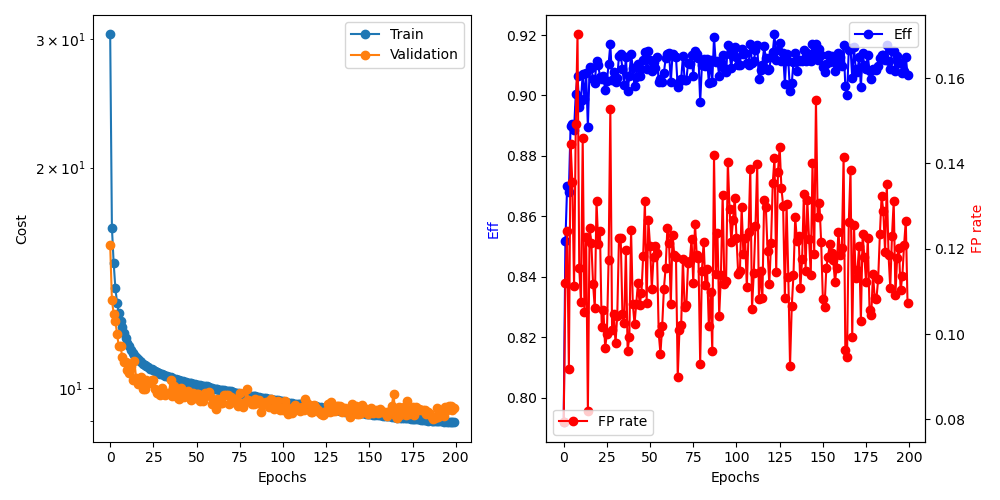

In [12]:
avgEff = 0.0
avgFP = 0.0
print('for model: ', model)   
run_name = 'Model Y (P2)'
# Create an mlflow run
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters of the model
    for key, value in vars(args).items():
        print(key, value)
        mlflow.log_param(key, value)
    
    # Log parameter count in the model
    mlflow.log_param('Parameters', count_parameters(model))
    
    # Begin run
    for result in trainNet(model, optimizer, loss,
                            train_loader, val_loader,
                            args.epochs+args.epoch_start, epoch_start=args.epoch_start,
                            notebook=True, device=device):

        result = result._asdict()
        results = results.append(pd.Series(result), ignore_index=True)
        xs = results.index

        # Update the plot above
        lines['train'].set_data(results.index, results.cost)
        lines['val'].set_data(results.index, results.val)

        #filter first cost epoch (can be really large)
        max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
        min_cost = min(min(results.cost), min(results.val))
    
        # The plot limits need updating too
        ax.set_ylim(min_cost*.9, max_cost*1.1)  
        ax.set_xlim(-.5, len(results.cost) - .5)
    
        replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
        replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))            
            
        # Redraw the figure
        fig.canvas.draw()
            
        ## MLFLOW ##
        # Log metrics
        mlflow.log_metric('Efficiency', result['eff_val'].eff_rate, result['epoch'])
        mlflow.log_metric('False Positive Rate',  result['eff_val'].fp_rate, result['epoch'])
        mlflow.log_metric('Validation Loss',  result['val'], result['epoch'])
        mlflow.log_metric('Training Loss',  result['cost'], result['epoch'])
        
        print('Result epoch: ', result['epoch'])
        if(result['epoch'] >= args.epochs + args.epoch_start - 10):
            avgEff += result['eff_val'].eff_rate
            avgFP += result['eff_val'].fp_rate
           
        if(result['epoch'] == args.epochs + args.epoch_start - 1):
            print('Averaging...\n')
            avgEff /= 10
            avgFP /= 10
            mlflow.log_metric('10 Efficiency Average', avgEff)
            mlflow.log_metric('10 False Positive Average', avgFP)
            
        print('Average Eff: ', avgEff)
        print('Average FP Rate: ', avgFP)
        
        # Log tags
#        mlflow.set_tag('Optimizer', 'Adam')
#        mlflow.set_tag('Kernel size', 'Mixed')
#        mlflow.set_tag('Skip connections', '4')
#        mlflow.set_tag('Activation', 'Softplus')
#        mlflow.set_tag('Mid Activation', 'Relu')
        mlflow.set_tag('Asymmetry', '2.5')

        # Save model state dictionary, optimizer state dictionary, and epoch number
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':args.epochs+result['epoch']
            }, 'run_stats.pyt')
        # Save the run stats into mlflow
        mlflow.log_artifact('run_stats.pyt')
        
    dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
    plt.tight_layout()
    # save plot
    plt.savefig('plot.png')  
    mlflow.log_artifact('plot.png')

In [13]:
##quit()